## Project description

Predicting the amount of taxi orders for the next hour using historical data on taxi orders at airports in order to identify peak hours and encourage more drivers to join. The RMSE metric will be used to evaluate performance.


# Table of contents

[Imports](#imports)


[1. Preparation](#1.-Preparation)

[Resampling](#Resampling)
   

[2. Analysis](#2.-Analysis)


[3. Training](#3.-Training)

[Splitting data](#Splitting-data)

[Creating features](#Creating-features)

[Linear regression](#Linear-regression)

[Random forest](#Random-forest)

[Catboost](#Catboost)

[4. Testing](#4.-Testing)

[Linear regression Final test](#Linear-regression-Final-test)

[Random forest Final test](#Random-forest-Final-test)

[CatBoost Final test](#CatBoost-Final-test)

[Conclusion](#Conclusion)

# Imports

In [1]:
#Imports
import os
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# 1. Preparation

In [2]:
os.chdir(r'C:\Users\Yael\Documents\yandex')
data = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.index.is_monotonic

True

In [7]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


## Resampling

In [8]:
data_edit = data.resample('1H').sum()

In [9]:
#extracting date parts
for attr in ['month', 'day','hour', 'dayofweek']:
        data_edit.loc[:,attr] = getattr(data_edit.index, attr)

In [10]:
data_edit.head()

,num_orders,month,day,hour,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,3,1,0,3
2018-03-01 01:00:00,85,3,1,1,3
2018-03-01 02:00:00,71,3,1,2,3
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,4,3


In [11]:
data_edit.describe()

,num_orders,month,day,hour,dayofweek
count,4416.000000,4416.000000,4416.000000,4416.00000,4416.000000
mean,84.422781,5.505435,15.836957,11.50000,3.005435
std,45.023853,1.713306,8.855229,6.92297,1.990684
min,0.000000,3.000000,1.000000,0.00000,0.000000
25%,54.000000,4.000000,8.000000,5.75000,1.000000
50%,78.000000,5.500000,16.000000,11.50000,3.000000
75%,107.000000,7.000000,23.250000,17.25000,5.000000
max,462.000000,8.000000,31.000000,23.00000,6.000000


# 2. Analysis

C:\Users\Yael\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of taxi orders')

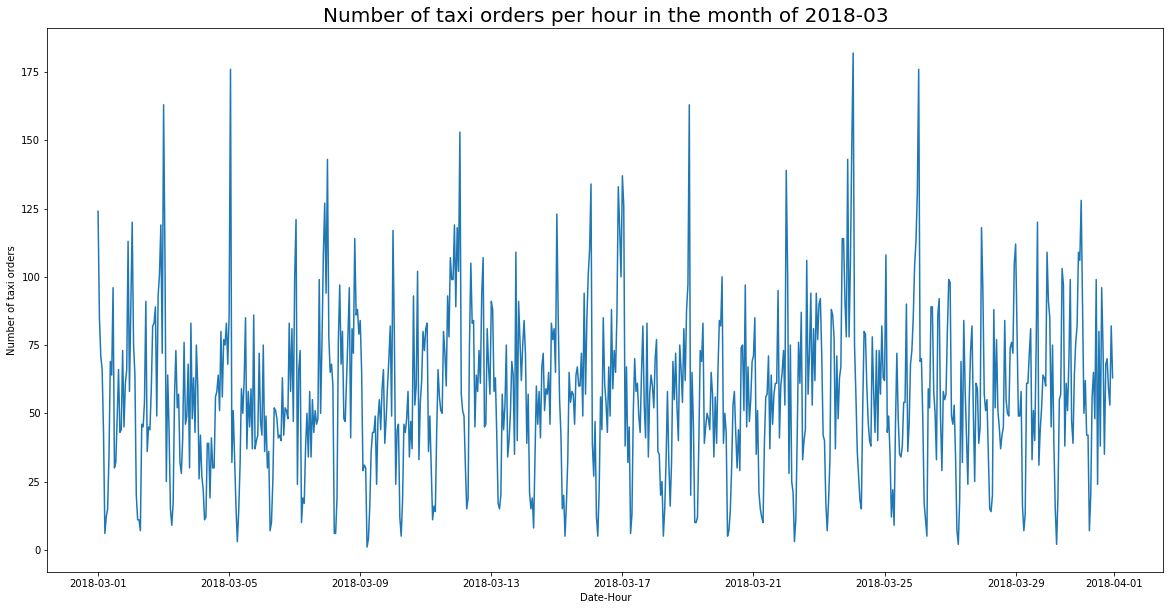

In [12]:
plt.figure(figsize=(20,10));
plt.plot(data_edit.loc['2018-03':'2018-03','num_orders'])
plt.title('Number of taxi orders per hour in the month of 2018-03',fontsize=20 )
plt.xlabel('Date-Hour')
plt.ylabel('Number of taxi orders')

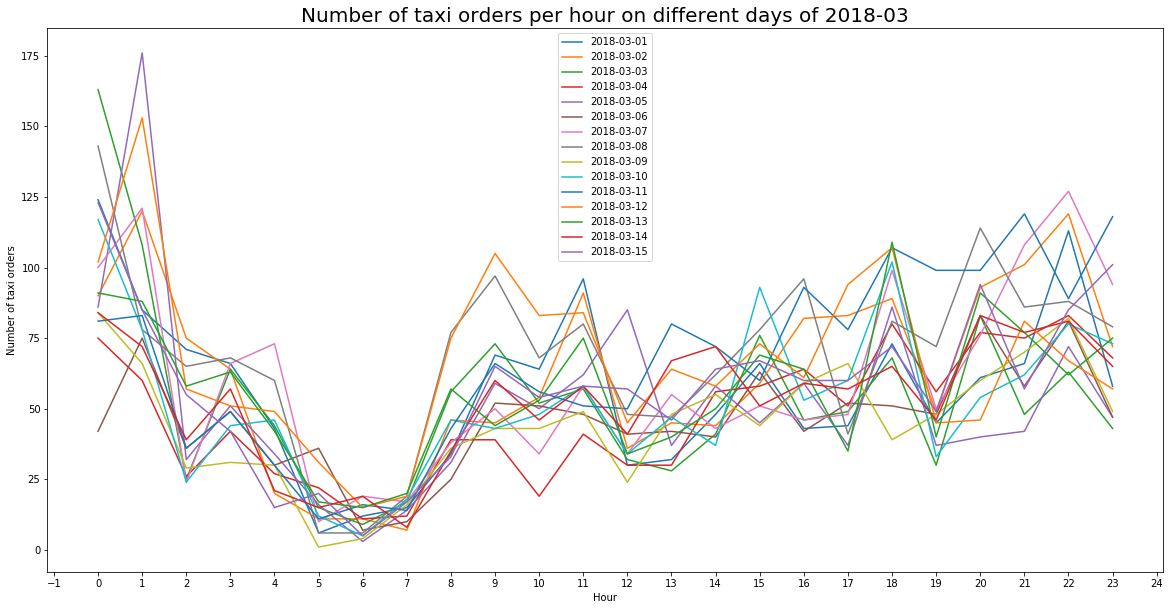

In [13]:
fig, ax = plt.subplots(figsize=(20,10));
for d in pd.date_range(start="2018-03-01",end="2018-03-15"):
    plt_date = str(d.date())
    ax.plot(data_edit.loc[plt_date:plt_date, 'hour'], data_edit.loc[plt_date:plt_date, 'num_orders'], label=(plt_date))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    
plt.title('Number of taxi orders per hour on different days of 2018-03', fontsize=20)
plt.xlabel('Hour')
plt.ylabel('Number of taxi orders')
plt.legend()

Looks like there are 2 kinds of graphs but with the same pattern of down time between 2:00-7:00, especially 5:00-7:00, and peak times at evening and night.

In [14]:
decomposed = seasonal_decompose(data_edit['num_orders'])

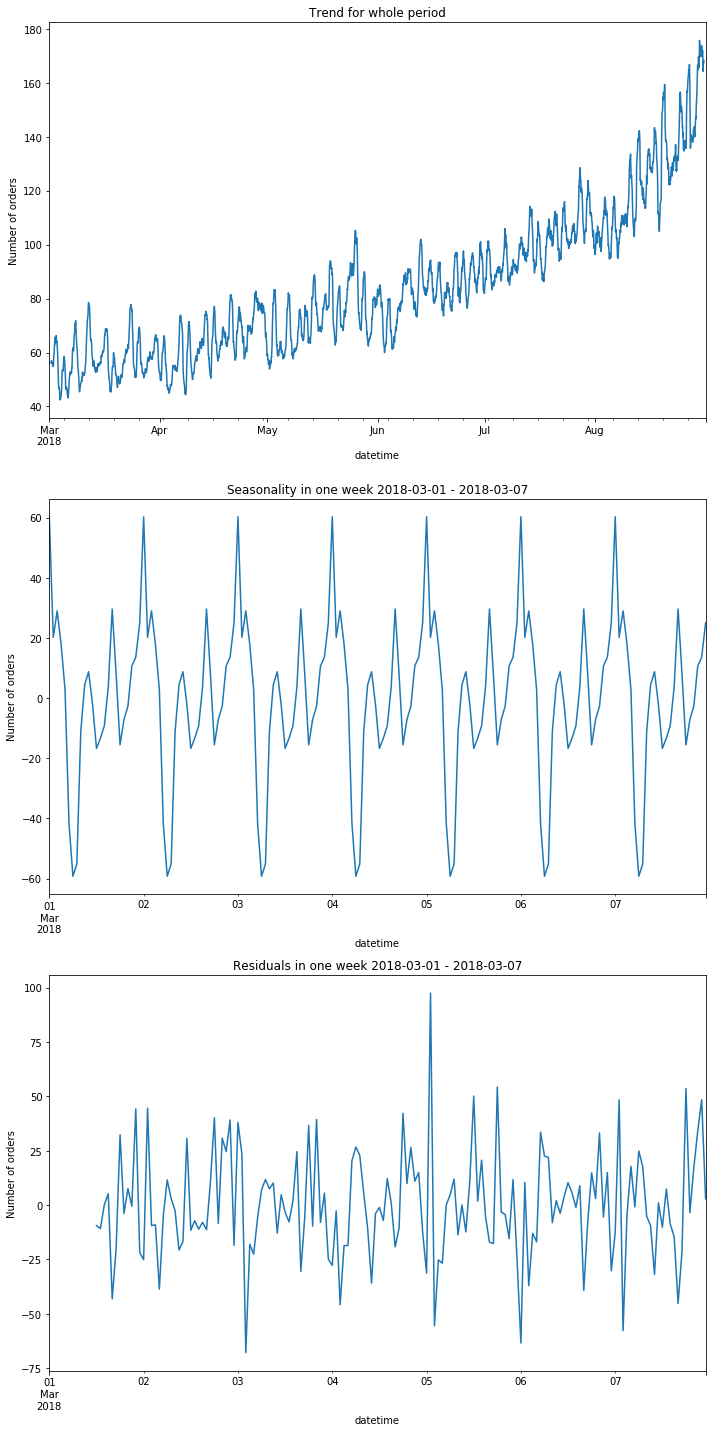

In [15]:

plt.figure(figsize=(10, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend for whole period')
plt.ylabel('Number of orders')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality in one week 2018-03-01 - 2018-03-07')
plt.ylabel('Number of orders')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Residuals in one week 2018-03-01 - 2018-03-07')
plt.ylabel('Number of orders')
plt.tight_layout()

- The trend graph shows an average growth in number of orders during 2018

- from seasonality we can see there is a recurrent pattern of orders each day but with a high variance since residuals reach high levels.

In [18]:
data_edit['mean_roll_7_days'] = data_edit['num_orders'].rolling(7*24).mean()
data_edit['std_roll_7_days'] = data_edit['num_orders'].rolling(7*24).std()

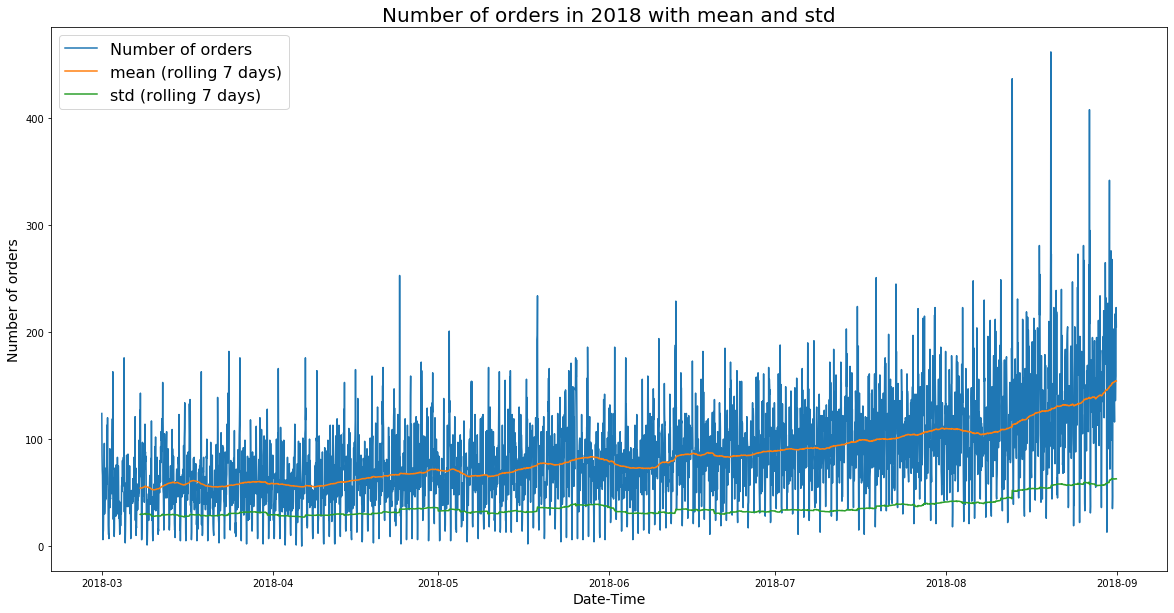

In [19]:
plt.figure(figsize=(20,10));
lines = plt.plot(data_edit.loc[:,['num_orders', 'mean_roll_7_days', 'std_roll_7_days']])
plt.xlabel('Date-Time', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.title('Number of orders in 2018 with mean and std', fontsize=20)
plt.legend(lines, ['Number of orders', 'mean (rolling 7 days)', 'std (rolling 7 days)'], fontsize=16);

In [20]:
data_edit['mean_roll_1_day'] = data_edit['num_orders'].rolling(24).mean()
data_edit['std_roll_1_day'] = data_edit['num_orders'].rolling(24).std()

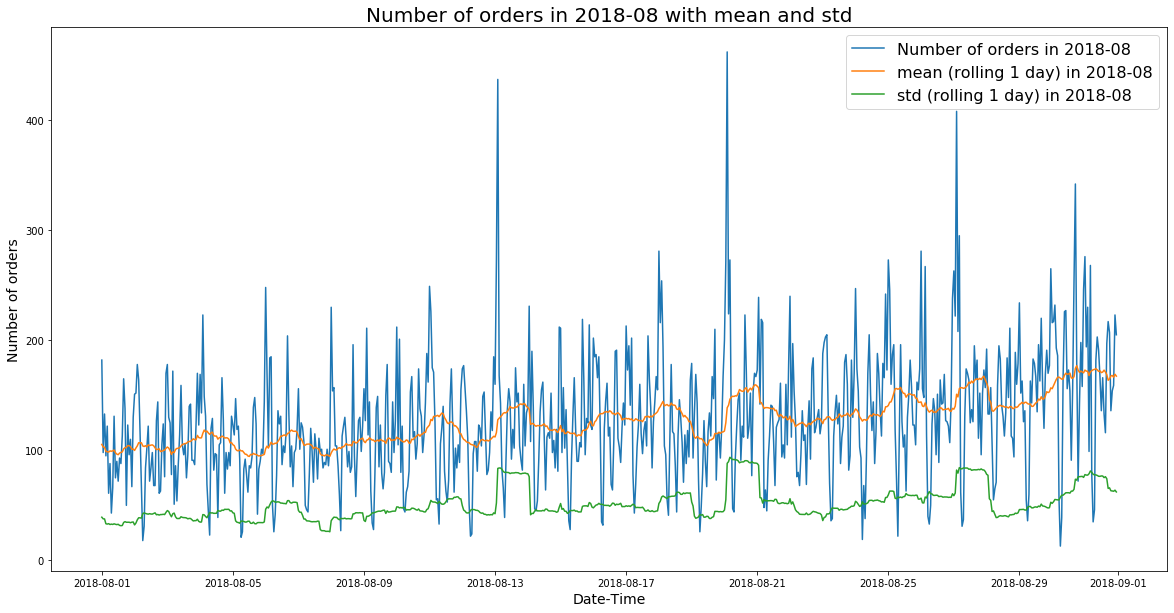

In [21]:
plt.figure(figsize=(20,10));
lines = plt.plot(data_edit.loc['2018-08':'2018-08',['num_orders', 'mean_roll_1_day', 'std_roll_1_day']])
plt.xlabel('Date-Time', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.title('Number of orders in 2018-08 with mean and std', fontsize=20)
plt.legend(lines, ['Number of orders in 2018-08', 'mean (rolling 1 day) in 2018-08', 'std (rolling 1 day) in 2018-08'], fontsize=16);

When rolling over a week the data is almost stationary, especially in the first three months.

# 3. Training

## Splitting data

In [22]:
train, test = train_test_split(data_edit.loc[:,['num_orders', 'month', 'day', 'hour', 'dayofweek']], \
                               shuffle=False, test_size=0.1)

In [23]:
tscv = TimeSeriesSplit(n_splits=3)

## Creating features

In [24]:
def make_features(data, max_lag, rolling_mean_size):   
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['lag_1'].rolling(rolling_mean_size).mean()

## Linear regression

In [25]:
train_edit = train.copy()

In [26]:
linear_res_cv = defaultdict(dict)

for max_lag in range(4, 8):
    for rolling_mean_size in [2, 12, 24, 3*24, 7*24]:
        make_features(train_edit, max_lag, rolling_mean_size)
        
        fold=0
        #cross validate linear regression
        for train_index, valid_index in tscv.split(train_edit):
            
            train_set =  train_edit.iloc[train_index,:].dropna()
            valid_set = train_edit.iloc[valid_index,:]
            
            #scaling features
            scaler = StandardScaler()
            scaler.fit(train_set)
            train_set = pd.DataFrame(scaler.transform(train_set), index=train_set.index, columns=train_set.columns)
            valid_set = pd.DataFrame(scaler.transform(valid_set), index=valid_set.index, columns=valid_set.columns)
            
            #make targets and features
            train_set_features = train_set.drop('num_orders', axis=1)
            train_set_target = train_set['num_orders']
            valid_set_features = valid_set.drop('num_orders', axis=1)
            valid_set_target =valid_set['num_orders']
                                
            #training
            model=LinearRegression()
                                 
            model.fit(train_set_features, train_set_target)
            pred = model.predict(valid_set_features)
            rmse = mean_squared_error(valid_set_target,pred)**0.5
            if fold==0:
                linear_res_cv[max_lag][rolling_mean_size] = rmse
            else:
                linear_res_cv[max_lag][rolling_mean_size] = np.average([linear_res_cv[max_lag][rolling_mean_size], rmse])
            fold+=1

In [27]:
for lag in linear_res_cv.keys():
    for roll in linear_res_cv[lag].keys():
        print('\nmax lag: ', lag, ' rolling mean size: ', roll, ' RMSE: ', linear_res_cv[lag][roll])


max lag:  4  rolling mean size:  2  RMSE:  1.0426128042934741

max lag:  4  rolling mean size:  12  RMSE:  1.0427060920342508

max lag:  4  rolling mean size:  24  RMSE:  1.0368816246217891

max lag:  4  rolling mean size:  72  RMSE:  1.0414061579604326

max lag:  4  rolling mean size:  168  RMSE:  1.0539317857042012

max lag:  5  rolling mean size:  2  RMSE:  1.0437207438152754

max lag:  5  rolling mean size:  12  RMSE:  1.0440141632766253

max lag:  5  rolling mean size:  24  RMSE:  1.0381105372173245

max lag:  5  rolling mean size:  72  RMSE:  1.042754549021062

max lag:  5  rolling mean size:  168  RMSE:  1.0560328427032233

max lag:  6  rolling mean size:  2  RMSE:  1.0449588100105696

max lag:  6  rolling mean size:  12  RMSE:  1.0433253666353692

max lag:  6  rolling mean size:  24  RMSE:  1.0372534577762917

max lag:  6  rolling mean size:  72  RMSE:  1.042089249263602

max lag:  6  rolling mean size:  168  RMSE:  1.0569166347171128

max lag:  7  rolling mean size:  2  RMSE:

The best RMSE result in linear regression cross validation is for max_lag=4 and rolling mean size of 24 hours

## Random forest

In [28]:
train_edit = train.copy()

In [29]:
RF_res_cv = defaultdict(dict)

for max_lag in range(4, 8):
    for rolling_mean_size in [2, 12, 24, 3*24, 7*24]:
        make_features(train_edit, max_lag, rolling_mean_size)
        
        RF_res_cv[max_lag][rolling_mean_size] = []
        for n in range(4,21):
            RF_model = RandomForestRegressor(max_depth=3, n_estimators = n, random_state = 12340+n)

            fold=0
            #cross validate
            for train_index, valid_index in tscv.split(train_edit):

                train_set =  train_edit.iloc[train_index,:].dropna()
                valid_set = train_edit.iloc[valid_index,:]

                #make targets and features
                train_set_features = train_set.drop('num_orders', axis=1)
                train_set_target = train_set['num_orders']
                valid_set_features = valid_set.drop('num_orders', axis=1)
                valid_set_target =valid_set['num_orders']

                #training

                RF_model.fit(train_set_features, train_set_target)
                pred = RF_model.predict(valid_set_features)
                
                if fold==0:
                    rmse = mean_squared_error(valid_set_target,pred)**0.5
                else:
                    rmse = np.average([rmse, mean_squared_error(valid_set_target,pred)**0.5])
                if fold==2:
                    RF_res_cv[max_lag][rolling_mean_size].append(round(rmse,3))
                
                fold+=1

In [30]:
for lag in RF_res_cv.keys():
    for roll in RF_res_cv[lag].keys():
        print('\nmax lag: ', lag, ' rolling mean size: ', roll,'RMSE: ', min(RF_res_cv[lag][roll]), ' n for min RMSE: ', \
              4+RF_res_cv[lag][roll].index(min(RF_res_cv[lag][roll])))


max lag:  4  rolling mean size:  2 RMSE:  35.399  n for min RMSE:  4

max lag:  4  rolling mean size:  12 RMSE:  35.076  n for min RMSE:  5

max lag:  4  rolling mean size:  24 RMSE:  35.062  n for min RMSE:  8

max lag:  4  rolling mean size:  72 RMSE:  34.867  n for min RMSE:  8

max lag:  4  rolling mean size:  168 RMSE:  34.805  n for min RMSE:  8

max lag:  5  rolling mean size:  2 RMSE:  35.296  n for min RMSE:  15

max lag:  5  rolling mean size:  12 RMSE:  35.078  n for min RMSE:  5

max lag:  5  rolling mean size:  24 RMSE:  35.038  n for min RMSE:  8

max lag:  5  rolling mean size:  72 RMSE:  34.859  n for min RMSE:  8

max lag:  5  rolling mean size:  168 RMSE:  34.8  n for min RMSE:  8

max lag:  6  rolling mean size:  2 RMSE:  35.407  n for min RMSE:  20

max lag:  6  rolling mean size:  12 RMSE:  35.113  n for min RMSE:  5

max lag:  6  rolling mean size:  24 RMSE:  35.03  n for min RMSE:  8

max lag:  6  rolling mean size:  72 RMSE:  34.86  n for min RMSE:  8

max lag:

The best RMSE result in Random forest with max_depth=3 cross validation is 34.79 for

max_lag=6,rolling mean size of 7 days, n=20

## Catboost

In [27]:
train_edit = train.copy()

In [28]:

CB_res_cv = defaultdict(dict)

for max_lag in range(4, 8):
    for rolling_mean_size in [2, 12, 24, 3*24, 7*24]:
        make_features(train_edit, max_lag, rolling_mean_size)

        CB_model = CatBoostRegressor(has_time=True, logging_level='Silent')

        #grid tuning hyper parameters
        grid = {'learning_rate': [0.03, 0.1, 0.5],
                'depth': [4, 6, 10, 12],
                'iterations': [10, 35, 50],
               'l2_leaf_reg': [2,4]
               }

        grid_search_result = CB_model.grid_search(grid,
                                                  cv=tscv, shuffle=False,
                                                  X=train_edit.drop('num_orders', axis=1), 
                                               y=train_edit['num_orders'], verbose=False)      

        CB_res_cv[max_lag][rolling_mean_size] = grid_search_result


In [29]:
for lag in CB_res_cv.keys():
    for roll in CB_res_cv[lag].keys():
        print('\nmax lag: ', lag, ' rolling mean size: ', roll, \
              ' min RMSE: ', np.min(CB_res_cv[lag][roll]['cv_results']['test-RMSE-mean']))


max lag:  4  rolling mean size:  2  min RMSE:  27.650518174584693

max lag:  4  rolling mean size:  12  min RMSE:  27.08506458232078

max lag:  4  rolling mean size:  24  min RMSE:  27.574967294679166

max lag:  4  rolling mean size:  72  min RMSE:  28.645297952227263

max lag:  4  rolling mean size:  168  min RMSE:  27.962186820353832

max lag:  5  rolling mean size:  2  min RMSE:  27.954193477952202

max lag:  5  rolling mean size:  12  min RMSE:  28.005687270902452

max lag:  5  rolling mean size:  24  min RMSE:  27.70309272252949

max lag:  5  rolling mean size:  72  min RMSE:  28.473605817159534

max lag:  5  rolling mean size:  168  min RMSE:  27.989445261158668

max lag:  6  rolling mean size:  2  min RMSE:  27.20096594499543

max lag:  6  rolling mean size:  12  min RMSE:  26.54971724952007

max lag:  6  rolling mean size:  24  min RMSE:  27.371225392547412

max lag:  6  rolling mean size:  72  min RMSE:  28.65312601793708

max lag:  6  rolling mean size:  168  min RMSE:  28.1

The best RMSE for cv in catboost is 26.55 for max lag = 6 and rooling mean size of 12 hours.

In [30]:
#catboost best params
CB_res_cv[6][12]['params']

{'depth': 4, 'l2_leaf_reg': 4, 'iterations': 50, 'learning_rate': 0.5}

# 4. Testing

Linear regression seem to have suspiciously low RMSE in parameter tuning. Catboost has lower RMSE than random forest. I would choose to use catboost but will test all three:

## CatBoost Final test

In [31]:
data_tmp = data_edit.loc[:,['num_orders', 'month', 'day', 'hour', 'dayofweek']].copy()
make_features(data_tmp, 6, 12)
train_tmp, test_tmp = train_test_split(data_tmp, shuffle=False, test_size=0.1)

#make targets and features
train_features = train_tmp.dropna().drop('num_orders', axis=1)
train_target = train_tmp.dropna()['num_orders']
test_features = test_tmp.drop('num_orders', axis=1)
test_target =test_tmp['num_orders']

CB_model = CatBoostRegressor(has_time=True, learning_rate=0.5,depth= 4,
        iterations=50, l2_leaf_reg=4)

CB_model.fit(train_features, train_target)

0:	learn: 33.0322313	total: 3.57ms	remaining: 175ms
1:	learn: 28.8002826	total: 6.71ms	remaining: 161ms
2:	learn: 26.9377420	total: 9.58ms	remaining: 150ms
3:	learn: 25.8596191	total: 12.2ms	remaining: 140ms
4:	learn: 25.7658357	total: 14ms	remaining: 126ms
5:	learn: 25.2350301	total: 15.5ms	remaining: 114ms
6:	learn: 25.1655604	total: 16.8ms	remaining: 103ms
7:	learn: 24.7828769	total: 18.1ms	remaining: 95.2ms
8:	learn: 24.6181566	total: 19.5ms	remaining: 88.7ms
9:	learn: 24.5734510	total: 20.8ms	remaining: 83ms
10:	learn: 24.0855257	total: 22.1ms	remaining: 78.5ms
11:	learn: 23.7446038	total: 23.8ms	remaining: 75.3ms
12:	learn: 23.3776124	total: 29.4ms	remaining: 83.7ms
13:	learn: 22.9917597	total: 31.5ms	remaining: 81ms
14:	learn: 22.6785369	total: 33.2ms	remaining: 77.5ms
15:	learn: 22.5387664	total: 34.8ms	remaining: 74ms
16:	learn: 22.3488930	total: 36.8ms	remaining: 71.3ms
17:	learn: 22.3232445	total: 38.6ms	remaining: 68.7ms
18:	learn: 22.2690104	total: 40.8ms	remaining: 66.5ms

In [32]:
CB_pred=CB_model.predict(test_features)
mean_squared_error(test_target,CB_pred)**0.5

45.30522394316804

RMSE for catBoost is lower than 48 as requested.

## Linear regression Final test

In [37]:
data_tmp = data_edit.loc[:,['num_orders', 'month', 'day', 'hour', 'dayofweek']].copy()
make_features(data_tmp, 4, 24)
train_tmp, test_tmp = train_test_split(data_tmp, shuffle=False, test_size=0.1)

#scaling features
scaler = StandardScaler()
scaler.fit(train_tmp)
train_scaled = pd.DataFrame(scaler.transform(train_tmp), index=train_tmp.index, columns=train_tmp.columns)
test_scaled = pd.DataFrame(scaler.transform(test_tmp), index=test_tmp.index, columns=test_tmp.columns)

#make targets and features
train_features = train_tmp.dropna().drop('num_orders', axis=1)
train_target = train_tmp.dropna()['num_orders']
test_features = test_tmp.drop('num_orders', axis=1)
test_target =test_tmp['num_orders']

#training
model=LinearRegression()

model.fit(train_features, train_target)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
pred=model.predict(test_features)
mean_squared_error(test_target,pred)**0.5

51.23257880330811

RMSE for linear regression is too high.

## Random forest Final test

In [39]:
data_tmp = data_edit.loc[:,['num_orders', 'month', 'day', 'hour', 'dayofweek']].copy()
make_features(data_tmp, 6, 7*24)
train_tmp, test_tmp = train_test_split(data_tmp, shuffle=False, test_size=0.1)

#make targets and features
train_features = train_tmp.dropna().drop('num_orders', axis=1)
train_target = train_tmp.dropna()['num_orders']
test_features = test_tmp.drop('num_orders', axis=1)
test_target =test_tmp['num_orders']

#training
RF_model = RandomForestRegressor(max_depth=3, n_estimators = 20, random_state = 12340+20)

RF_model.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=12360,
                      verbose=0, warm_start=False)

In [40]:
RF_pred=RF_model.predict(test_features)
mean_squared_error(test_target,RF_pred)**0.5

60.443229593076424

RMSE for random forest much too high.

# Conclusion

The best results for predicting the number of orders in terms of RMSE are in the case of training canBoost model with max lag time of 6 and a rolling mean size of 12 hours.
The RMSE is 46.57

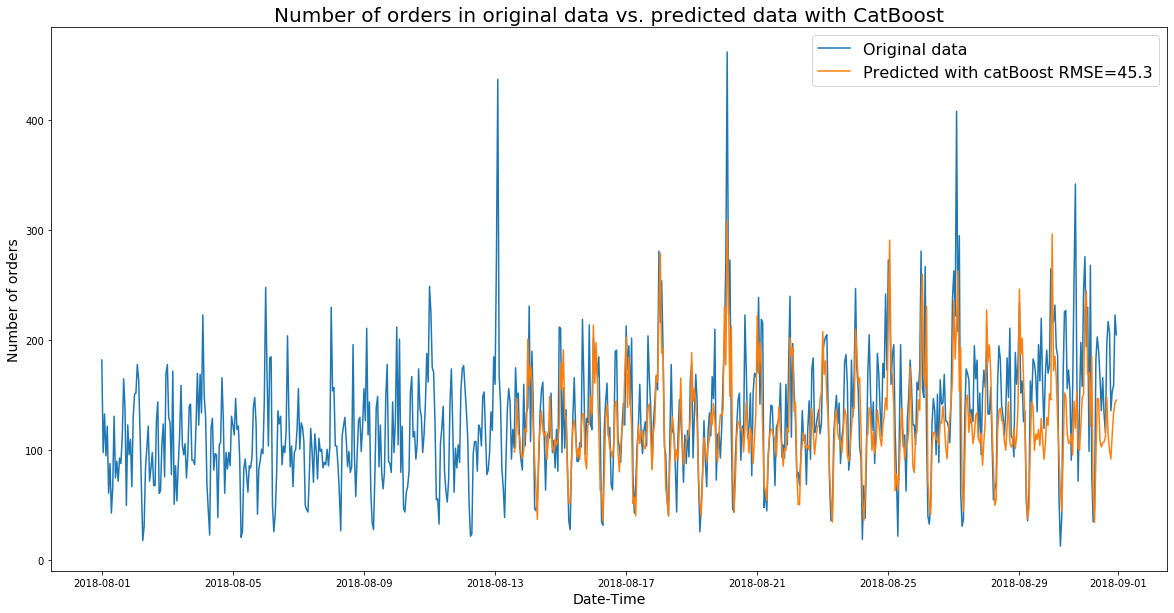

In [34]:
plt.figure(figsize=(20,10));
plt.plot(data_edit.loc['2018-08':'2018-09','num_orders'], label='Original data')
plt.plot(pd.Series(CB_pred, index=test_target.index), label='Predicted with catBoost RMSE=45.3')
plt.xlabel('Date-Time', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.title('Number of orders in original data vs. predicted data with CatBoost', fontsize=20)
plt.legend(fontsize=16)


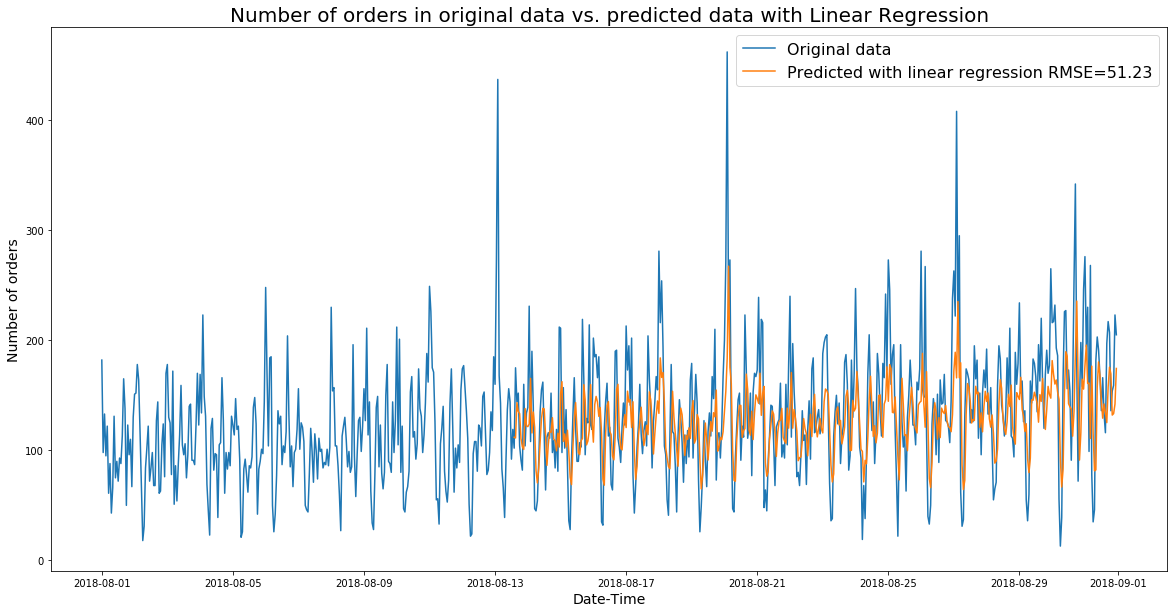

In [42]:
plt.figure(figsize=(20,10));
plt.plot(data_edit.loc['2018-08':'2018-09','num_orders'], label='Original data')
plt.plot(pd.Series(pred, index=test_target.index), label='Predicted with linear regression RMSE=51.23')
plt.xlabel('Date-Time', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.title('Number of orders in original data vs. predicted data with Linear Regression', fontsize=20)
plt.legend(fontsize=16)


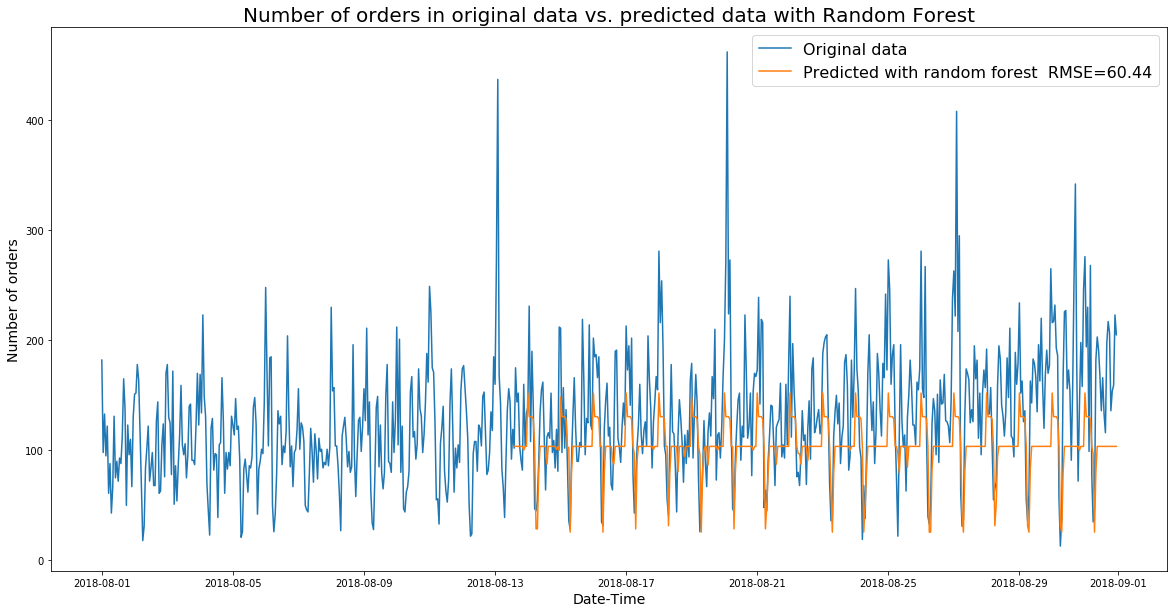

In [43]:
plt.figure(figsize=(20,10));
plt.plot(data_edit.loc['2018-08':'2018-09','num_orders'], label='Original data')
plt.plot(pd.Series(RF_pred, index=test_target.index), label='Predicted with random forest  RMSE=60.44')
plt.xlabel('Date-Time', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.title('Number of orders in original data vs. predicted data with Random Forest', fontsize=20)
plt.legend(fontsize=16)
